In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
import seaborn as sns
from scipy.stats import skew
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [51]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 20
train_file_path = '/home/matheus/PycharmProjects/HousePrices/data/train.csv'
test_file_path = '/home/matheus/PycharmProjects/HousePrices/data/test.csv'
train = pd.read_csv(train_file_path)
test = pd.read_csv(test_file_path)

all_data = pd.concat([train.loc[:,:"SaleCondition"], test.loc[:,:"SaleCondition"]], sort = False)
numeric_feats = all_data.loc[:, :"SaleCondition"].dtypes[all_data.dtypes != "object"].index
skewed_feats = all_data.loc[:,numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])
change_to_none = ["Alley", "MasVnrType","MiscFeature"]
change_to_no = ["BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2",
                "FireplaceQu", "GarageType","PoolQC","Fence"]
all_data.loc[:, "MasVnrArea"] = all_data.loc[:, "MasVnrArea"].fillna(0)
all_data.loc[:,change_to_none] = all_data.loc[:,change_to_none].fillna("None")
all_data.loc[:,change_to_no] = all_data.loc[:,change_to_no].fillna("No") 

all_data = all_data.fillna(all_data.mean())
all_data.columns[all_data.isna().any()].tolist()
all_data = pd.get_dummies(all_data)
train = pd.get_dummies(train)
train['SalePrice'] = np.log1p(train['SalePrice'])
def list_corr(var="SalePrice", ascend=True):
    corr_m = train.corr().sort_values(var,ascending=ascend)
    return corr_m[var]
corr = list_corr()

positive = corr.where(corr>0.1).dropna().keys()

negative = corr.where(corr<-0.1).dropna().keys()
print(negative.shape)
features = positive
def matriz_corr(features):
    #correlation matrix
    corrmat = train[features].corr()
    f, ax = plt.subplots(figsize=(12, 9))
    sns.heatmap(corrmat, vmax=.8, square=True);
print(positive.shape)

(62,)
(77,)


In [52]:
list_corr(ascend=False)

SalePrice                1.000000
OverallQual              0.817185
GrLivArea                0.700927
GarageCars               0.680625
GarageArea               0.650888
TotalBsmtSF              0.612134
1stFlrSF                 0.596981
FullBath                 0.594771
YearBuilt                0.586570
YearRemodAdd             0.565608
GarageYrBlt              0.541073
TotRmsAbvGrd             0.534422
Foundation_PConc         0.530840
ExterQual_Gd             0.509675
Fireplaces               0.489450
HeatingQC_Ex             0.466706
BsmtQual_Ex              0.463991
BsmtFinType1_GLQ         0.440764
MasVnrArea               0.430809
GarageFinish_Fin         0.418881
GarageType_Attchd        0.415787
KitchenQual_Ex           0.413937
KitchenQual_Gd           0.406601
BsmtFinSF1               0.372023
GarageCond_TA            0.365783
ExterQual_Ex             0.356134
LotFrontage              0.355879
Neighborhood_NridgHt     0.351803
CentralAir_Y             0.351599
FireplaceQu_Gd

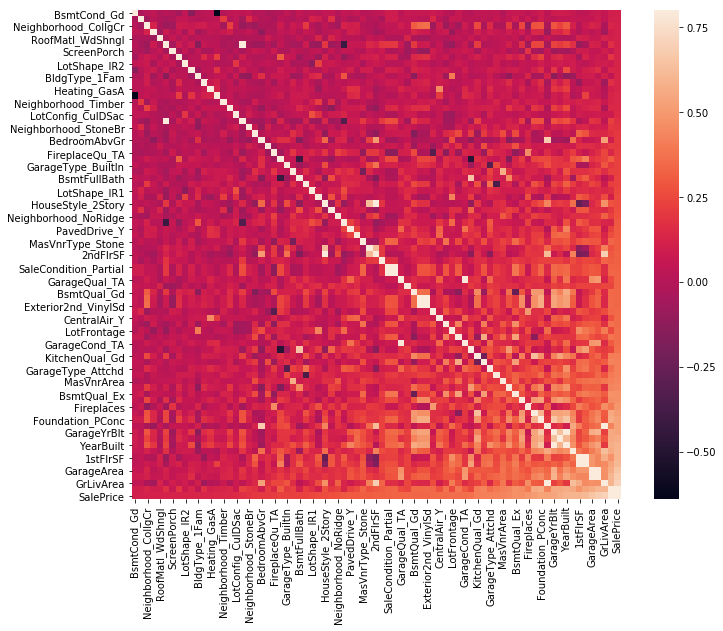

In [53]:
matriz_corr(positive)

In [54]:
#features_to_drop = ["GarageArea","1stFlrSF","TotRmsAbvGrd","GarageYrBlt", "GarageCond_TA","HouseStyle_2Story", "SalePrice"]
features = pd.Index(["Id"]).append(positive.drop(features_to_drop))
print(features)
all_data = all_data.loc[:, features]

NameError: name 'features_to_drop' is not defined

In [ ]:
matriz_corr(features[1:])

In [ ]:

sns.distplot(train['SalePrice']) 

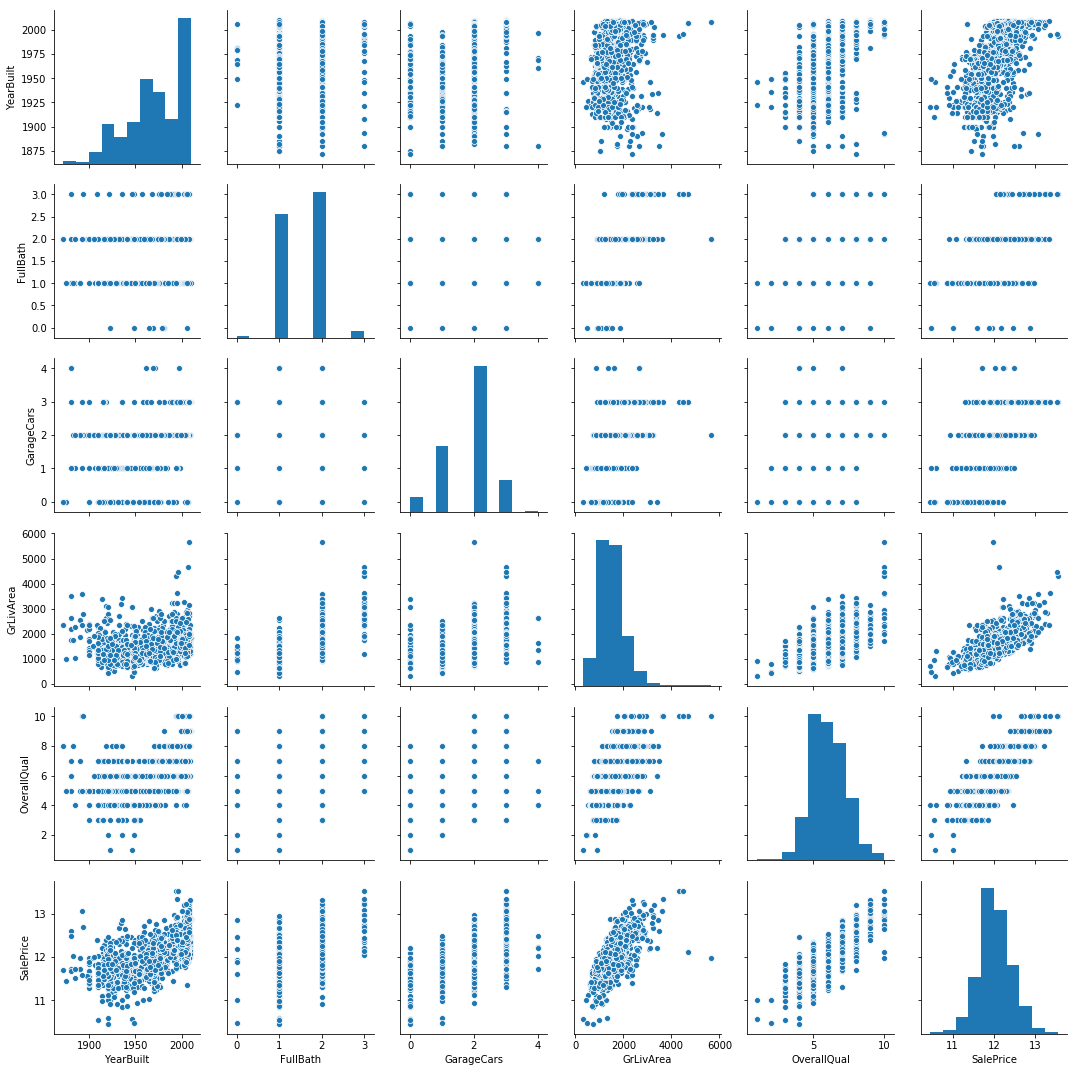

In [55]:
cols = ['YearBuilt', 'FullBath', 'GarageCars',
       'GrLivArea', 'OverallQual','SalePrice']
sns.pairplot(train[cols], height = 2.5)

In [56]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model, X, y):
    rmse= np.sqrt(-cross_val_score(model,X, y, scoring="neg_mean_squared_error", cv = 5))
    return rmse

In [57]:
from sklearn.linear_model import Ridge, SGDRegressor
X = all_data[:train.shape[0]]
y = train.SalePrice
X_test = all_data[train.shape[0]:]



Text(0, 0.5, 'rmse')

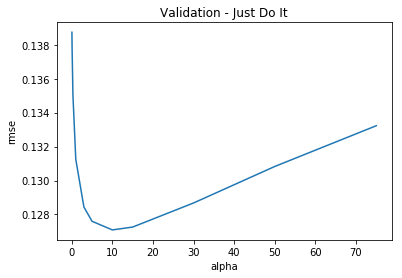

In [58]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha),X,y).mean() 
            for alpha in alphas]
y.shape
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [59]:
#test.loc[0,"Neighborhood_NridgHt":"OverallQual"].values
cv_ridge.idxmin()
rmse_cv(SGDRegressor(max_iter=10000,tol=0.00001),X,y).mean()

4722129821973530.0

In [60]:
def residual_plot(y_train_pred,y):
    y_rsd = y_train_pred - y
    plt.scatter(y_train_pred, y_rsd, c = "blue", label = "Training data")
    plt.xlabel("Predict Values")
    plt.ylabel("Residuals")
    plt.hlines(y = 0, xmin = min(y_train_pred), xmax =  max(y_train_pred), color = "red")# plotar a reta

Best alpha : 10.0


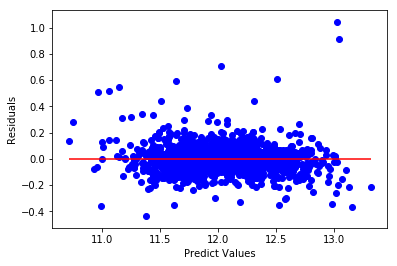

In [61]:
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60]).fit(X,y)
alpha = ridge.alpha_
print("Best alpha :", alpha)
residual_plot(ridge.predict(X), y)

Text(0, 0.5, 'Residuals')

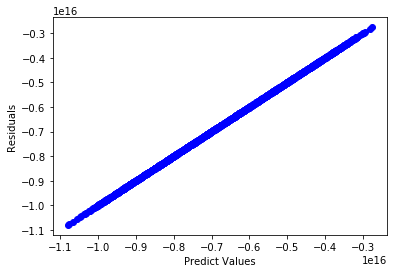

In [62]:
sgd = SGDRegressor(max_iter=1000, tol=0.0001).fit(X,y)
y_pred = sgd.predict(X)
r = y_pred - y
plt.scatter(y_pred, r, c = 'blue', label = "Training data")
plt.xlabel("Predict Values")
plt.ylabel("Residuals")

In [63]:
ridge_preds = ridge.predict(X_test)

In [64]:
model_lasso = LassoCV(alphas=[0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60],cv=5)
rmse_cv(model_lasso,X,y).mean()

0.14955761603301948

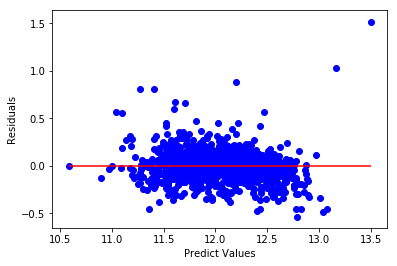

In [65]:
model_lasso.fit(X,y)
lasso_preds = np.expm1(model_lasso.predict(X_test))
residual_plot( model_lasso.predict(X), y)

In [66]:
rmse_cv(RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60]),X,y).mean()

0.12738925105853427

In [67]:
from sklearn.svm import SVR
svr_model = SVR(kernel='rbf',gamma='scale', C=200, epsilon=0.03)
#svr_model.fit(X,y)
#sp = svr_model.predict(X_test)
#print(mean_squared_error(sp, np.log1p(y_

In [70]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(X.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model
model = build_model()
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  X, y,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [ ]:
test_predictions = 

In [85]:
ann = model.predict(X)
rp = ridge.predict(X)
lp = model_lasso.predict(X)
#sp = svr_model.predict(X)
ann = np.reshape(ann,1460)
train_preds = 0.6*rp + 0.3*lp + 0.1*ann
print(mean_squared_error(ann ,y))
print(mean_squared_error(rp ,y))
print(mean_squared_error(lp, y))
print(mean_squared_error(train_preds, y))
#print(mean_squared_error(sp, y))
#residual_plot(train_preds, y)

ann.shape

0.05981836966157301
0.01110304568240516
0.02181971205742578
0.013260229945517366


(1460,)

In [88]:
ann = model.predict(X_test)
rp = ridge.predict(X_test)
lp = model_lasso.predict(X_test)
ann = np.reshape(ann,ann.shape[0])
preds = 0.7*rp + 0.3*lp 
preds = np.expm1(preds)
submission = pd.DataFrame({'Id':test.Id,'SalePrice':preds})

In [87]:
submission.to_csv('submission.csv',index=False)
pd.read_csv('submission.csv')

,Id,SalePrice
0,1461,131765.997305
1,1462,155535.525677
2,1463,188048.403339
3,1464,206358.703704
4,1465,206363.657305
5,1466,175147.013968
6,1467,182437.381582
7,1468,168167.043666
8,1469,197065.567838
9,1470,124239.261292
